In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Akhil PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
model = SentenceTransformer('all-MiniLM-L12-v2')

In [7]:

# Load the Excel files
theme_df = pd.read_excel(r"C:\Users\Akhil PC\Documents\internships\SPJIMR - Internship\methodology paper\SDg.xlsx")
corpus_df = pd.read_excel(r"C:\Users\Akhil PC\Documents\internships\SPJIMR - Internship\methodology paper\sentences.xlsx")

corpus_df.head()

,company,sentence,label
0,Sun Pharma,The Company’s CSR policy encompasses the compa...,CSR 1 - General
1,Sun Pharma,Sun Pharma is committed to making a positive i...,CSR 1 - General
2,Sun Pharma,The company has contributed ₹100.00 Million du...,CSR 6 - Community
3,Sun Pharma,The project has been undertaken to set up a la...,CSR 5 - Products
4,Sun Pharma,The project aims to provide access to safe and...,CSR 6 - Community


In [8]:
## all unique labels

corpus_df['label'].unique()

array(['CSR 1 - General', 'CSR 6 - Community', 'CSR 5 - Products',
       'CSR 2 - Environmental', 'CSR 3 - Energy',
       'CSR 4 - Human Resources', 'CSR 7 - Fair Business Practices'],
      dtype=object)

In [9]:
# Clean the label column by removing "CSR n - " prefix
corpus_df['label'] = corpus_df['label'].str.replace(r'CSR \d+ - ', '', regex=True)

# Verify the unique values in the cleaned label column
corpus_df['label'].unique()

array(['General', 'Community', 'Products', 'Environmental', 'Energy',
       'Human Resources', 'Fair Business Practices'], dtype=object)

In [10]:
theme_df.head(7)

,Goal,Description,Example Sentences
0,Goal 1: End Poverty in All Its Forms Everywhere,End poverty in all its forms everywhere.,"By 2030, eradicate extreme poverty for all peo..."
1,"Goal 2: End Hunger, Achieve Food Security, Imp...","End hunger, achieve food security and improved...","By 2030, end hunger and ensure access to safe,..."
2,Goal 3: Ensure Healthy Lives and Promote Well-...,Ensure healthy lives and promote well-being fo...,"By 2030, reduce the global maternal mortality ..."
3,Goal 4: Ensure Inclusive and Equitable Quality...,Ensure inclusive and equitable quality educati...,"By 2030, ensure that all girls and boys comple..."
4,Goal 5: Achieve Gender Equality and Empower Al...,Achieve gender equality and empower all women ...,End all forms of discrimination against all wo...
5,Goal 6: Ensure Availability and Sustainable Ma...,Ensure availability and sustainable management...,"By 2030, achieve universal and equitable acces..."
6,"Goal 7: Ensure Access to Affordable, Reliable,...","Ensure access to affordable, reliable, sustain...","By 2030, ensure universal access to affordable..."


In [11]:
# Process theme data
theme_data = []
for idx, row in theme_df.iterrows():
    instrument = row['Goal']
    sentences = row['Example Sentences'].split(';')
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:  # Skip empty sentences
            theme_data.append({
                'label': instrument,
                'sentence': sentence
            })

theme_processed_df = pd.DataFrame(theme_data)
theme_processed_df.head()

,label,sentence
0,Goal 1: End Poverty in All Its Forms Everywhere,"By 2030, eradicate extreme poverty for all peo..."
1,Goal 1: End Poverty in All Its Forms Everywhere,Proportion of the population living below the ...
2,Goal 1: End Poverty in All Its Forms Everywhere,"By 2030, reduce at least by half the proportio..."
3,Goal 1: End Poverty in All Its Forms Everywhere,Proportion of population living below the nati...
4,Goal 1: End Poverty in All Its Forms Everywhere,"Proportion of men, women, and children living ..."


In [12]:
# Generate embeddings for theme sentences
theme_embeddings = model.encode(theme_processed_df['sentence'].tolist())
theme_processed_df['embedding'] = list(theme_embeddings)


# Generate embeddings for corpus sentences
corpus_embeddings = model.encode(corpus_df['sentence'].tolist())
corpus_df['embedding'] = list(corpus_embeddings)

In [ ]:
# Set threshold for cosine similarity
SIMILARITY_THRESHOLD = 0.4

# Matching algorithm
def find_best_match(embedding, threshold=SIMILARITY_THRESHOLD):
    similarities = cosine_similarity([embedding], theme_embeddings)[0]
    max_similarity_idx = np.argmax(similarities)
    max_similarity = similarities[max_similarity_idx]
    
    if max_similarity >= threshold:
        return theme_processed_df.iloc[max_similarity_idx]['label'], max_similarity
    else:
        return "unmatched", max_similarity

# Apply matching algorithm to corpus
results = []
for idx, row in corpus_df.iterrows():
    pred_label, similarity = find_best_match(row['embedding'])
    results.append({
        'company': row['company'],
        'sentence': row['sentence'],
        'true_label': row['label'],
        'predicted_label': pred_label,
        'similarity_score': similarity
    })

# Create results dataframe
results_df = pd.DataFrame(results)

In [26]:
results_df.head()

,company,sentence,true_label,predicted_label,similarity_score
0,Sun Pharma,The Company’s CSR policy encompasses the compa...,General,Goal 12: Ensure Sustainable Consumption and Pr...,0.515184
1,Sun Pharma,Sun Pharma is committed to making a positive i...,General,Goal 12: Ensure Sustainable Consumption and Pr...,0.374837
2,Sun Pharma,The company has contributed ₹100.00 Million du...,Community,"Goal 9: Build Resilient Infrastructure, Promot...",0.279082
3,Sun Pharma,The project has been undertaken to set up a la...,Products,"Goal 9: Build Resilient Infrastructure, Promot...",0.369885
4,Sun Pharma,The project aims to provide access to safe and...,Community,Goal 6: Ensure Availability and Sustainable Ma...,0.422769


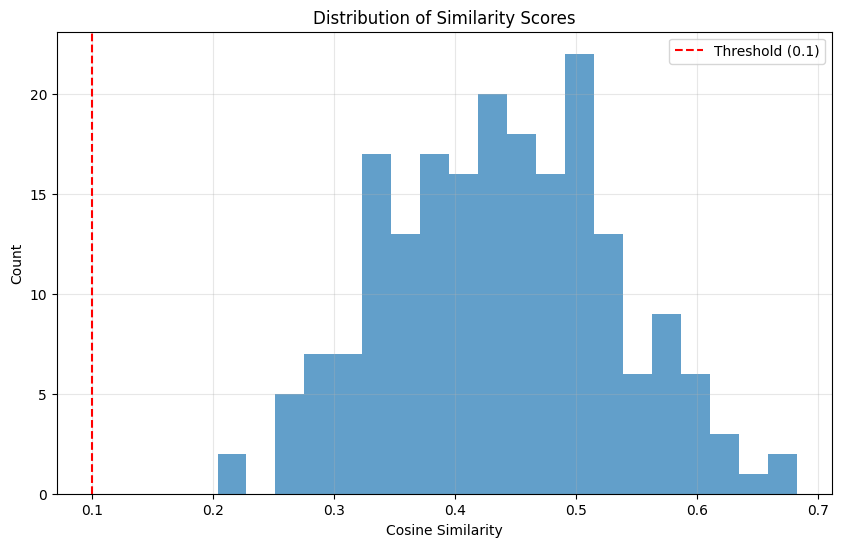

In [27]:
# Distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(results_df['similarity_score'], bins=20, alpha=0.7)
plt.axvline(x=SIMILARITY_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({SIMILARITY_THRESHOLD})')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
# Extract top 5 matching sentences for each CSR category
categories = theme_processed_df['label'].unique()

# Create a nice formatted display of results
print("# Top 5 Matching Sentences for Each SDG\n")

for category in categories:
    # Filter results for this category
    category_matches = results_df[results_df['predicted_label'] == category]
    
    # Sort by similarity score in descending order and take top 5
    top_matches = category_matches.sort_values('similarity_score', ascending=False).head(5)
    
    print(f"## {category}")
    print("-" * 80)
    
    if len(top_matches) > 0:
        for i, (_, row) in enumerate(top_matches.iterrows(), 1):
            print(f"**{i}. Score: {row['similarity_score']:.3f} - {row['company']}**")
            print(f"Sentence: \"{row['sentence']}\"\n")
    else:
        print("No matches found.\n")
    
    print("\n")

# Top 5 Matching Sentences for Each SDG

## Goal 1: End Poverty in All Its Forms Everywhere
--------------------------------------------------------------------------------
**1. Score: 0.659 - ITC Limited**
Sentence: "Provide relief to the poor and vulnerable sections of society who face severe disruption to their livelihoods in the event of disasters and calamities, directly or through government bodies."

**2. Score: 0.568 - ITC Limited**
Sentence: "Target the needy and poor through interventions that enable income generation, and also provide access to basic needs like clothing, food, etc., as needed."

**3. Score: 0.532 - Wipro Ltd**
Sentence: "Rural livelihood programs aim to enhance economic opportunities and sustainable development in villages."

**4. Score: 0.523 - Wipro Ltd**
Sentence: "Disaster Relief initiatives focus on providing emergency support and rehabilitation for affected communities."

**5. Score: 0.508 - Reliance Industries Ltd**
Sentence: "Reliance Foundation supp

In [30]:
# Extract top 5 and bottom 5 matching sentences for each SDG
categories = theme_processed_df['label'].unique()

# Create a nice formatted display of results
print("# Top 5 and Bottom 5 Matching Sentences for Each SDG\n")

for category in categories:
    print(f"## {category}")
    print("-" * 80)
    
    # Get all corpus sentences with predictions for this category
    # For top matches: use the filtered results with the threshold applied
    category_matches = results_df[results_df['predicted_label'] == category]
    
    # For bottom matches: ignore threshold and look at all sentences with this category as the closest match
    # This requires looking at the raw similarity scores before threshold filtering
    all_matches_for_category = pd.DataFrame(results)
    bottom_candidates = all_matches_for_category[
        all_matches_for_category['predicted_label'] == category
    ]
    
    # Top 5 matches (using thresholded results)
    print("### Top 5 Matches:")
    if len(category_matches) > 0:
        top_matches = category_matches.sort_values('similarity_score', ascending=False).head(5)
        for i, (_, row) in enumerate(top_matches.iterrows(), 1):
            print(f"**{i}. Score: {row['similarity_score']:.3f} - {row['company']}**")
            print(f"Sentence: \"{row['sentence']}\"\n")
    else:
        print("No matches found above threshold.\n")
    
    # Bottom 5 matches (ignoring threshold)
    print("\n### Bottom 5 Matches:")
    if len(bottom_candidates) > 0:
        bottom_matches = bottom_candidates.sort_values('similarity_score').head(5)
        for i, (_, row) in enumerate(bottom_matches.iterrows(), 1):
            print(f"**{i}. Score: {row['similarity_score']:.3f} - {row['company']}**")
            print(f"Sentence: \"{row['sentence']}\"\n")
    else:
        print("No matches found for this category.\n")
    
    print("\n")

# Top 5 and Bottom 5 Matching Sentences for Each SDG

## Goal 1: End Poverty in All Its Forms Everywhere
--------------------------------------------------------------------------------
### Top 5 Matches:
**1. Score: 0.659 - ITC Limited**
Sentence: "Provide relief to the poor and vulnerable sections of society who face severe disruption to their livelihoods in the event of disasters and calamities, directly or through government bodies."

**2. Score: 0.568 - ITC Limited**
Sentence: "Target the needy and poor through interventions that enable income generation, and also provide access to basic needs like clothing, food, etc., as needed."

**3. Score: 0.532 - Wipro Ltd**
Sentence: "Rural livelihood programs aim to enhance economic opportunities and sustainable development in villages."

**4. Score: 0.523 - Wipro Ltd**
Sentence: "Disaster Relief initiatives focus on providing emergency support and rehabilitation for affected communities."

**5. Score: 0.508 - Reliance Industries Ltd**
Sen

In [31]:
# Extract top 5 and bottom 5 matching sentences for each SDG theme
categories = theme_processed_df['label'].unique()

# Create a nice formatted display of results
print("# Top 5 and Bottom 5 Matching Sentences for Each SDG\n")

for category in categories:
    print(f"## {category}")
    print("-" * 80)
    
    # Get all theme sentences for this category
    theme_category_embeddings = theme_embeddings[theme_processed_df['label'] == category]
    
    # If we have multiple theme sentences for this category, average them
    if len(theme_category_embeddings) > 0:
        category_embedding = np.mean(theme_category_embeddings, axis=0)
        
        # Calculate similarity between this category and all corpus sentences
        similarities = cosine_similarity([category_embedding], corpus_embeddings)[0]
        
        # Create temporary dataframe with all similarities
        temp_df = corpus_df.copy()
        temp_df['similarity'] = similarities
        
        # Get top 5 and bottom 5
        top5 = temp_df.sort_values('similarity', ascending=False).head(5)
        bottom5 = temp_df.sort_values('similarity').head(5)
        
        # Display top 5
        print("### Top 5 Most Similar Sentences:")
        for i, (_, row) in enumerate(top5.iterrows(), 1):
            print(f"**{i}. Score: {row['similarity']:.3f} - {row['company']}**")
            print(f"Sentence: \"{row['sentence']}\"\n")
        
        # Display bottom 5
        print("\n### Bottom 5 Least Similar Sentences:")
        for i, (_, row) in enumerate(bottom5.iterrows(), 1):
            print(f"**{i}. Score: {row['similarity']:.3f} - {row['company']}**")
            print(f"Sentence: \"{row['sentence']}\"\n")
    else:
        print("No theme sentences found for this category.\n")
    
    print("\n")

# Top 5 and Bottom 5 Matching Sentences for Each SDG

## Goal 1: End Poverty in All Its Forms Everywhere
--------------------------------------------------------------------------------
### Top 5 Most Similar Sentences:
**1. Score: 0.653 - ITC Limited**
Sentence: "Provide relief to the poor and vulnerable sections of society who face severe disruption to their livelihoods in the event of disasters and calamities, directly or through government bodies."

**2. Score: 0.610 - ITC Limited**
Sentence: "Target the needy and poor through interventions that enable income generation, and also provide access to basic needs like clothing, food, etc., as needed."

**3. Score: 0.520 - ITC Limited**
Sentence: "Create sustainable livelihoods and alleviate poverty through promotion of afforestation, water stewardship, sustainable agriculture and climate smart practices, livestock development and women empowerment."

**4. Score: 0.508 - L&T**
Sentence: "100% of the Projects serve the beneficiaries who 